In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import scipy.optimize as spo

In [2]:
# ----------- convenciones ------------------
dias_mes=30
dia_año=360
dia_prestamo=365
#================== caracteristicas de los contratos en días ===================

plazos_tasas=[3*dias_mes,6*dias_mes,12*dias_mes,2*dia_año,3*dia_año,5*dia_año,7*dia_año,10*dia_año]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

# Abrir datos

In [3]:
datos=pd.read_excel("datos_taller.xlsx", index_col=0)/100

In [4]:
datos=datos.resample("W").last()

Asignar a cada prestamo los dias de duración

In [5]:
plazos={}
for i in range(len(datos.columns)):
    plazos[datos.columns[i]]=plazos_tasas[i]
plazos

{'ICE LIBOR USD 3 Month': 90,
 'ICE LIBOR USD 6 Month': 180,
 'ICE LIBOR USD 12 Month': 360,
 'USD SWAP SEMI 30/360 2YR': 720,
 'USD SWAP SEMI 30/360 3YR': 1080,
 'USD SWAP SEMI 30/360 5YR': 1800,
 'USD SWAP SEMI 30/360 7YR': 2520,
 'USD SWAP SEMI 30/360 10Y': 3600}

In [6]:
tipo={}
instrumento=["libor","libor","libor","swap","swap","swap","swap","swap"]
for i in range(len(datos.columns)):
    tipo[i]=instrumento[i]
tipo

{0: 'libor',
 1: 'libor',
 2: 'libor',
 3: 'swap',
 4: 'swap',
 5: 'swap',
 6: 'swap',
 7: 'swap'}

In [7]:
nombre={}
for i in range(len(datos.columns)):
    nombre[i]=datos.columns[i]
nombre

{0: 'ICE LIBOR USD 3 Month',
 1: 'ICE LIBOR USD 6 Month',
 2: 'ICE LIBOR USD 12 Month',
 3: 'USD SWAP SEMI 30/360 2YR',
 4: 'USD SWAP SEMI 30/360 3YR',
 5: 'USD SWAP SEMI 30/360 5YR',
 6: 'USD SWAP SEMI 30/360 7YR',
 7: 'USD SWAP SEMI 30/360 10Y'}

# Curva forward

In [8]:
def intervalo(df):
    # Esta función tiene el objetivo de crear un intervalo en forma de vector
    # Me devuelve un array de nx2
    x=np.array([np.array(df[i:i+2]) for i in range(len(df)-1)])
    return x

[0, 90, 360, 1080, 1800, 3600] 6


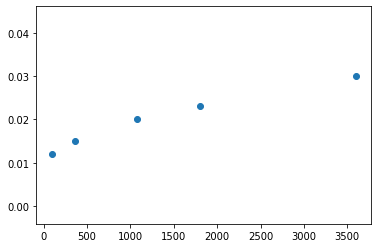

In [9]:
#=================== Aplico esta función al plazo que tengo para la curva =======================
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]
intervalo_curva=intervalo(plazo_curva)

print(plazo_curva,len(plazo_curva))

# ====================== Gráfico la curva con los valores iniciales ======================
tasas_curva=[0.012,0.015,0.02,0.023,0.03]
plt.scatter(plazo_curva[1:],tasas_curva)

In [10]:
# ========================== Veo como está el intervalo ===================================
intervalo_curva

array([[   0,   90],
       [  90,  360],
       [ 360, 1080],
       [1080, 1800],
       [1800, 3600]])

### Funciones para la creación de los plazos de la curva a la medidad del instrumento y el DF

In [11]:
def plazo_curva_fw(plazo_instrumento, plazos_curva):
    #plazo_instrumento: plazo de vencicimiento del instrumento
    #plazo_curva: plazos de la curva forward
    
    # Con esta fórmula construyo la base de plazos, teniendo en cuenta la duración del instrumento
    # lo que intento hacer es encontrar el mínimo entre los plazos
    # de esta manera si el venciemiento es menor al plazo tomo como referencia el plazo
    nuevos_plazos=[]
    for plazo in plazos_curva:
        nuevos_plazos=np.append(nuevos_plazos,min(plazo,plazo_instrumento))
    
    return intervalo(nuevos_plazos)
    
def DF(tasas_forwards, plazos):
    #tasa_forwards: tasas de la curva
    #plazos: plazos de a los que quiero valorar cada instrumento
    #tipo: tipo de crédito swap o libor
    
    #=========== Esto solo sirve para libor ===============================
    
    #con esta fórmula encuentro el factor de descuente para cada fecha
    #el factor se inicia en cero porque es el tiempo t=1
    # la fórmila sirve tanto para sacar los factores de descuento de libor y swaps
    # deja como variables las tasas forwards
    factor_d=[]
   
    for i in range(len(tasas_forwards)):
        periodo=(plazos[i][1]-plazos[i][0])/dia_año
        if periodo==0:
            FD_1=1
            factor_d=np.append(factor_d,FD_1)
        else:
            FD_1=np.exp(-tasas_forwards[i]*(periodo))#FD_1=mt.exp(-tasas_forwards[i])
            factor_d=np.append(factor_d,FD_1)
                
    return factor_d

In [12]:
#verificar que hace formula
plazo_curva_fw(30*3,plazo_curva)

array([[ 0., 90.],
       [90., 90.],
       [90., 90.],
       [90., 90.],
       [90., 90.]])

In [13]:
años=7
2*(años*360/360)

14.0

In [14]:
#verificar que hace la formula de los factores
DF(tasas_curva,plazo_curva_fw(30*3,plazo_curva))

array([0.9970045, 1.       , 1.       , 1.       , 1.       ])

# Fórmulas de valoración

In [15]:
def libor(tasa,tipo_libor,tasas_curva):
    # Con esta formula puedo saber cuanto se debe pagar al final del periodo con un crédito Libor
    #tasa: tasa libor para el periodo t
    # tipo libor: tipo de contrato
    # plazo curva: plazos de las curva forward
    global plazo_curva
    tipo=tipo_libor
    plazo_dias=plazos[tipo]
    vf_libor=100*(1+tasa*(plazo_dias/360))
    fechas=plazo_curva_fw(plazo_dias,plazo_curva)
    vp_libor=vf_libor*DF(tasas_curva,fechas).prod()
    return vp_libor

def fd_swaps(plazo_vencimiento,tasas_curva):
    # plazo vencimiento: plazo en el que vence el contrato 
    # con esta fórmula puedo sacar el valor presente de un crédito libor o un crédito diferente
    # para cada factor de descuento
    global plazo_curva
    factor=0
    factor_final=0
    for i in range(int(plazo_vencimiento/360)*2):
        fd=DF(tasas_curva,plazo_curva_fw((i+1)*6*30,plazo_curva)).prod()
        factor+=fd
        factor_final=fd
    return factor,factor_final

def swap(cupon,tipo_swap,tasas_curva):
    # cupon: valor en % del cupon. Dejarlo expresado en decimales
    # Tipo de swap es el nombre del swap segun bloomberg
    tipo=tipo_swap
    plazo_dias=plazos[tipo]
    fd=fd_swaps(plazo_dias,tasas_curva)
    vp_swap=100*(1/2)*cupon*fd[0]+100*fd[1]
    return vp_swap

In [16]:
tasas_curva=[0.015,0.015,0.02,0.023,0.03]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

fd_swaps(2*360,tasas_curva)

(3.9185553227081, 0.9656054162575665)

In [17]:
instrumento=4
swap(datos.iloc[0][instrumento],nombre[instrumento],tasas_curva)

101.33543214327665

In [18]:
nombre[0]

'ICE LIBOR USD 3 Month'

In [19]:
instrumento=0
libor(datos.iloc[1][1],nombre[0],[0.015,0.018,0.02,0.023,0.03])
#libor(datos.iloc[0][datos.columns[columna]],datos.columns[columna],tasas_curva)[0]

100.1068321227058

In [20]:
#verificar que hace la formula de los factores
DF([0.015,0.018,0.02,0.023,0.03],plazo_curva_fw(30*3,plazo_curva)).prod()

0.996257022469171

In [21]:
instrumento=0
libor(datos.iloc[1][1],nombre[0],[0.015,0.015,0.02,0.023,0.03])
#libor(datos.iloc[0][datos.columns[columna]],datos.columns[columna],tasas_curva)[0]

100.1068321227058

In [22]:
DF([0.015,0.015,0.02,0.023,0.03],plazo_curva_fw(30*3,plazo_curva)).prod()

0.996257022469171

In [23]:
np.array(datos.iloc[0])

array([0.0172152, 0.0188769, 0.0217313, 0.021946 , 0.022975 , 0.023949 ,
       0.024604 , 0.025405 ])

# Metodo de calibración

### Función de evaluación 

In [24]:
def error_cuadrado(tasas_curva,datos):
    # función a optimizar
    # tasa_curva: son las tasas que se quieren encontrar
    # datos es el dato para una fecha específica
    global plazo_curva
    global tipo
    error_cuadrado=0
    for instrumento in range(len(datos)):
        if tipo[instrumento]=="libor":
            error=100-libor(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado+=error**2
        else:
            error=100-swap(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado+=error**2
    return error_cuadrado

### Optimizador

In [34]:
np.random.seed(12345)
tasas_iniciales=np.random.uniform(size=5)
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

def optimizador(datos,error_cuadrado):
    global plazo_curva
    global tasas_iniciales
    # Encuentre el mínimo error posible, bajo las tasas de la cuerva forward
    result=spo.minimize(error_cuadrado,tasas_iniciales,args=(datos,),method="Nelder-Mead",options={"disp":True})
    return result

In [35]:
datos.iloc[-1:]

,ICE LIBOR USD 3 Month,ICE LIBOR USD 6 Month,ICE LIBOR USD 12 Month,USD SWAP SEMI 30/360 2YR,USD SWAP SEMI 30/360 3YR,USD SWAP SEMI 30/360 5YR,USD SWAP SEMI 30/360 7YR,USD SWAP SEMI 30/360 10Y
Dates,,,,,,,,
2020-02-16,0.017037,0.017254,0.018127,0.01489,0.014509,0.014585,0.015051,0.015894


In [36]:
#================ Prueba del optimizador =====================================
result=optimizador(datos.loc["2020-02-16"],error_cuadrado)
result.x

Optimization terminated successfully.
         Current function value: 0.029862
         Iterations: 435
         Function evaluations: 707


array([0.01677703, 0.01790484, 0.01266259, 0.01444584, 0.01728496])

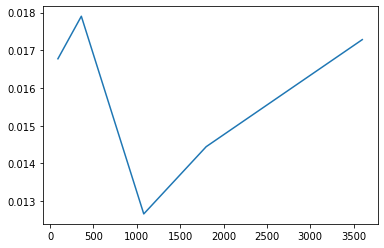

In [37]:
plt.plot(plazo_curva[1:],result.x)

In [38]:
tasa_fwrd=[]
for fecha in datos.index:
    tasas_iniciales=np.random.uniform(size=5)
    tasa_fwrd=np.append(optimizador(datos.loc[fecha],error_cuadrado).x,tasa_fwrd)

Optimization terminated successfully.
         Current function value: 0.026747
         Iterations: 603
         Function evaluations: 976
Optimization terminated successfully.
         Current function value: 0.020663
         Iterations: 418
         Function evaluations: 678
Optimization terminated successfully.
         Current function value: 0.027435
         Iterations: 439
         Function evaluations: 712
Optimization terminated successfully.
         Current function value: 0.028348
         Iterations: 400
         Function evaluations: 644
Optimization terminated successfully.
         Current function value: 0.022304
         Iterations: 258
         Function evaluations: 410
Optimization terminated successfully.
         Current function value: 0.023669
         Iterations: 466
         Function evaluations: 750
Optimization terminated successfully.
         Current function value: 0.024075
         Iterations: 393
         Function evaluations: 623
Optimization termina

Optimization terminated successfully.
         Current function value: 1.900724
         Iterations: 222
         Function evaluations: 374
Optimization terminated successfully.
         Current function value: 0.436962
         Iterations: 271
         Function evaluations: 444
Optimization terminated successfully.
         Current function value: 0.037979
         Iterations: 399
         Function evaluations: 647
Optimization terminated successfully.
         Current function value: 0.028076
         Iterations: 620
         Function evaluations: 992
Optimization terminated successfully.
         Current function value: 0.026221
         Iterations: 381
         Function evaluations: 612
Optimization terminated successfully.
         Current function value: 0.029080
         Iterations: 402
         Function evaluations: 655
Optimization terminated successfully.
         Current function value: 0.034034
         Iterations: 441
         Function evaluations: 723
Optimization termina

In [39]:
x_tasas=np.array([np.array(tasa_fwrd[i:i+5]) for i in range(0,len(tasa_fwrd)-1,5)])
x_tasas

array([[ 0.01681923,  0.01788065,  0.01267988,  0.01442937,  0.01728883],
       [ 0.01702761,  0.01803235,  0.01194006,  0.01393212,  0.01675715],
       [ 0.01722041,  0.01772607,  0.01045585,  0.01331711,  0.01585695],
       [ 0.01775384,  0.01848086,  0.01325824,  0.01478428,  0.01766332],
       [ 0.35619875, -0.11188123,  0.01899175,  0.02226155,  0.0178836 ],
       [ 0.01818939,  0.01933675,  0.01424852,  0.0163471 ,  0.01918583],
       [ 0.01859127,  0.01918739,  0.01392887,  0.01624177,  0.01903511],
       [ 0.01913586,  0.01954475,  0.01486085,  0.01719512,  0.01995195],
       [-0.024386  ,  0.1084949 , -0.01381889,  0.02011043,  0.01826726],
       [ 0.01915474,  0.01900724,  0.01439688,  0.01625493,  0.01890179],
       [ 0.19333401, -0.04615241,  0.01727167,  0.01616878,  0.01908547],
       [ 0.0189401 ,  0.0189914 ,  0.01393458,  0.01569208,  0.01821153],
       [ 0.01928259,  0.01851358,  0.0138608 ,  0.01506758,  0.01794336],
       [ 0.09413559, -0.02914817,  0.0

In [40]:
tasas_forward_finales=pd.DataFrame(x_tasas,index=datos.index)
tasas_forward_finales.to_csv("tasas_finales abs.csv")

In [41]:
tasas_forward_finales=pd.read_csv("tasas_finales.csv", index_col="Dates")

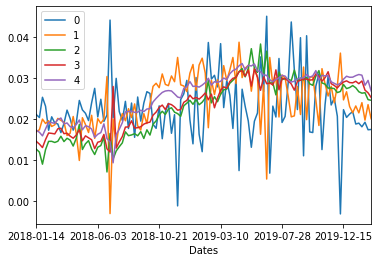

In [42]:
tasas_forward_finales.plot()

# Valoración prestamos

In [50]:
def fd_credito(plazo_vencimiento,tasas_curva):
    # plazo vencimiento: plazo en el que vence el contrato 
    # con esta fórmula puedo sacar el valor presente de un crédito libor o un crédito diferente
    # para cada factor de descuento
    global plazo_curva
    factor=0
    factor_final=0
    for i in range(int(plazo_vencimiento/360)):
        fd=DF(tasas_curva,plazo_curva_fw((i+1)*360,plazo_curva)).prod()
        factor+=fd
        factor_final=fd
    return factor,factor_final

def credito(cupon,plazo_año,tasas_curva,nocional):
    # cupon: valor en % del cupon. Dejarlo expresado en decimales. Usar fòrmula del cupon para saber su valor
    # plazo en años de la duraciòn del cupon
    # tasas_curva: tasas a las que se va a valorar el bono
    # valor de nocional en dòlares
    plazo_dias=plazo_año*360
    fd=fd_credito(plazo_dias,tasas_curva)
    vp_credito=nocional*cupon*fd[0]+nocional*fd[1]
    vf_credito=nocional*cupon/fd[0]+nocional/fd[1]
    return vp_credito,vf_credito

def cupon(plazo_año,tasas_curva):
    # plazo_años: plazo en años de la duraciòn del bono
    # tasas curva: tasa con las que se va a realizar la valoraciòn del bono
    plazo_dias=plazo_año*360
    fd=fd_credito(plazo_dias,tasas_curva)
    cupon=(1-fd[1])/fd[0]
    return cupon

In [51]:
tasa_valoracion_bono=result.x
cupon=cupon(7,tasa_valoracion_bono)
credito(cupon,7,tasa_valoracion_bono,50000000)

(50000000.0, 55729762.60441599)

# PCA de los factores

In [52]:
#======================= X - Creo una matriz de los cambios
x=tasas_forward_finales-tasas_forward_finales.shift(1)
x=x.dropna()

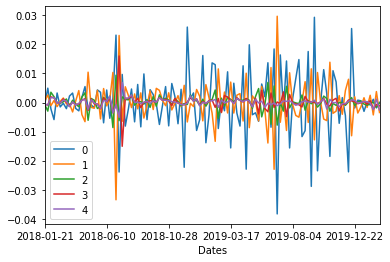

In [53]:
x.plot()

In [66]:
import scipy.linalg as la
def componentes(df):
    varcov=df.cov()
    vals = pd.DataFrame(la.eig(varcov)[0])
    porcentaje=vals/vals.sum()
    cum_perct=porcentaje.cumsum()
    SQRTvals= pd.DataFrame(vals.apply(mt.sqrt, axis= 1))
    vecs = pd.DataFrame(la.eig(varcov)[1])
    return vals, vecs, SQRTvals, cum_perct

In [67]:
comp_=componentes(x)[1] 
comp_

,0,1,2,3,4
0,-0.838455,0.512161,-0.114103,0.142485,-0.036909
1,0.531217,0.692679,-0.304371,0.359476,-0.127043
2,-0.105632,-0.459915,-0.645124,0.566727,0.199888
3,0.058282,0.198559,0.145448,-0.003666,0.967476
4,-0.015689,-0.083300,0.676017,0.727518,-0.080833


In [144]:
componentes(x)[3] 

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\pandas\core\series.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  return converter(self.iloc[0])


,0
0,0.868361+0.000000j
1,0.956216+0.000000j
2,0.959119+0.000000j
3,0.971126+0.000000j
4,1.000000+0.000000j


In [68]:
np.dot(np.sqrt(componentes(x)[0]).T,componentes(x)[1])

array([[-0.00891731+0.j,  0.00948092+0.j, -0.00143192+0.j,
         0.00560087+0.j,  0.00044166+0.j]])

### Prueba con Scipy

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(x)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.8683613  0.08785432 0.02887424 0.01200685 0.00290329]
[0.13798541 0.04388989 0.0251616  0.01622548 0.00797862]


In [70]:
pca.singular_values_/pca.singular_values_.sum()

array([0.59671689, 0.1898015 , 0.10881115, 0.07016696, 0.0345035 ])

In [71]:
pca.components_

array([[-0.83845512,  0.53121732, -0.10563233,  0.05828234, -0.0156891 ],
       [-0.51216132, -0.69267873,  0.45991543, -0.19855932,  0.08330042],
       [ 0.03690944,  0.12704265, -0.19988752, -0.96747554,  0.08083271],
       [ 0.14248519,  0.35947593,  0.56672659, -0.00366572,  0.72751809],
       [ 0.11410282,  0.30437077,  0.64512446, -0.14544764, -0.67601656]])

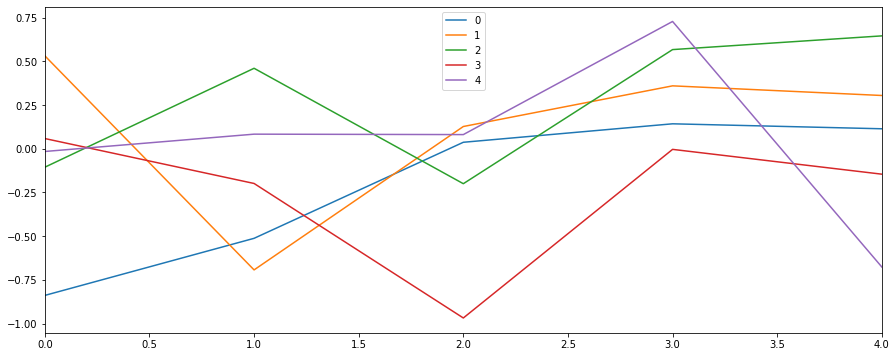

In [72]:
pd.DataFrame(pca.components_).plot(figsize=(15,6))

In [ ]:
# COntinuación

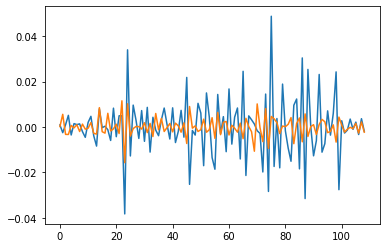

In [145]:
componente_1=np.dot(x,comp_[comp_.columns[0]])
componente_2=np.dot(x,comp_[comp_.columns[1]])
plt.plot(componente_1)
plt.plot(componente_2)

In [146]:
componente_1.shape

(109,)

# Arima

In [160]:
import pmdarima as pm
from pmdarima.arima import auto_arima


df_1=componente_1
model = pm.auto_arima(df_1, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-708.194, BIC=-697.429, Fit time=0.531 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-629.801, BIC=-624.418, Fit time=0.094 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-679.753, BIC=-671.679, Fit time=0.172 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-705.845, BIC=-697.771, Fit time=0.272 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-631.800, BIC=-629.109, Fit time=0.034 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-706.680, BIC=-693.224, Fit time=0.707 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 0); AIC=-703.835, BIC=-690.378, Fit time=0.135 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 0); AIC=-706.406, BIC=-695.641, Fit time=0.498 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-687.102, BIC=-676.336, Fit time=0.150 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_o

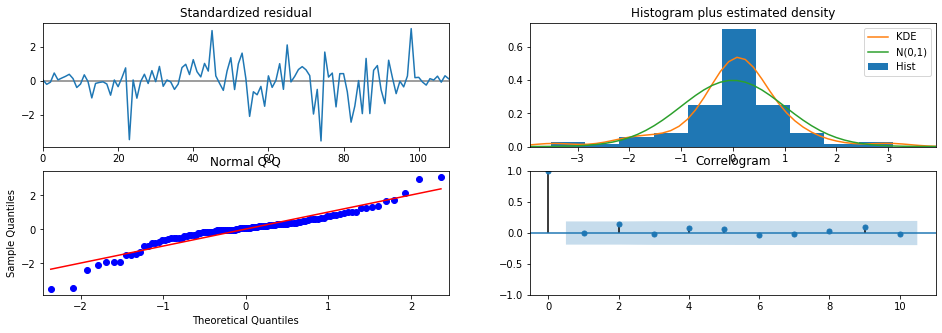

In [161]:
model.plot_diagnostics(figsize=(16,5))
plt.show()

In [168]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(endog=df_1,order=(2,0,0),enforce_invertibility=False)
results=model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 347.547
Date:                Fri, 28 Feb 2020   AIC                           -689.094
Time:                        00:02:26   BIC                           -681.020
Sample:                             0   HQIC                          -685.820
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7965      0.089     -8.904      0.000      -0.972      -0.621
ar.L2         -0.2892      0.106     -2.717      0.007      -0.498      -0.081
sigma2      9.895e-05   9.88e-06     10.014      0.0

1.09234146535839e-05


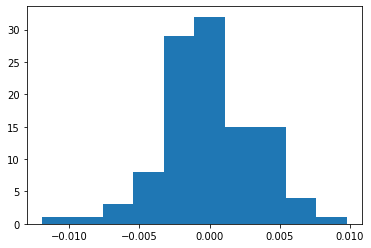

In [174]:
plt.hist(results.resid)
print(np.var(results.resid))

In [169]:
df_2=componente_2
model2 = pm.auto_arima(df_2, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model2.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-948.422, BIC=-937.657, Fit time=0.621 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-879.512, BIC=-874.129, Fit time=0.103 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-929.473, BIC=-921.399, Fit time=0.145 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-929.065, BIC=-920.991, Fit time=0.273 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-881.504, BIC=-878.813, Fit time=0.033 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-947.213, BIC=-933.756, Fit time=0.266 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 0); AIC=-947.054, BIC=-933.597, Fit time=0.342 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 0); AIC=-949.830, BIC=-939.065, Fit time=0.243 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 0); AIC=-945.987, BIC=-929.839, Fit time=0.357 seconds
Fit ARIMA: order=(0, 0, 3) seasonal_o

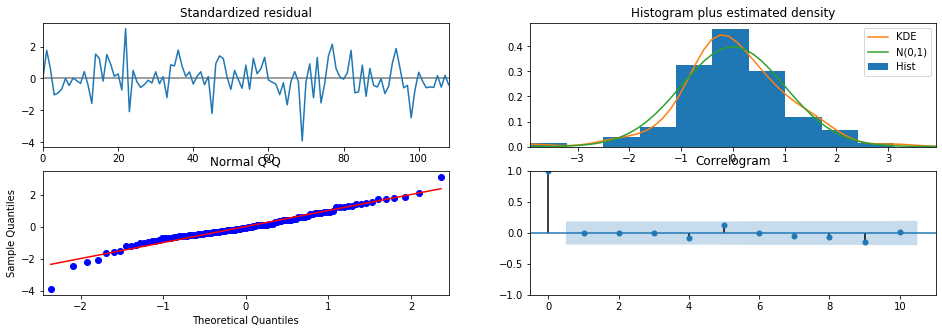

In [170]:
model2.plot_diagnostics(figsize=(16,5))
plt.show()

In [172]:
import statsmodels.api as sm
model2=sm.tsa.statespace.SARIMAX(endog=df_2,order=(1,0,0),enforce_invertibility=False)
results2=model2.fit()
print(results2.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 467.726
Date:                Fri, 28 Feb 2020   AIC                           -931.453
Time:                        00:04:21   BIC                           -926.070
Sample:                             0   HQIC                          -929.270
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6188      0.064     -9.628      0.000      -0.745      -0.493
sigma2      1.091e-05   1.18e-06      9.282      0.000    8.61e-06    1.32e-05
Ljung-Box (Q):                       52.31   Jarque-

1.09234146535839e-05


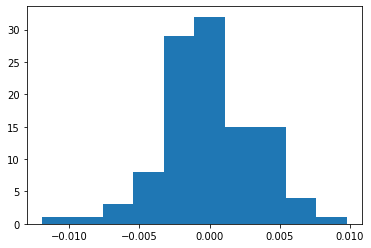

In [173]:
plt.hist(results2.resid)
print(np.var(results2.resid))

# Modelación del error

In [134]:
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = dist_names = ['chi', 'chi2',  'dweibull', 'expon','genpareto',
                                        'lognorm',  'norm', 'pareto', 
                                        't']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n), param
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        plt.hist(x, alpha=0.5, label='Fitted')
        plt.hist(y, alpha=0.5, label='Actual')
        plt.legend(loc='upper right')

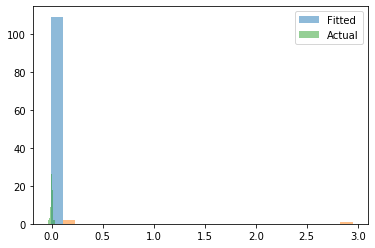

In [137]:
dst = Distribution()
dst.Fit(results.resid)
dst.Plot(results.resid)


C:\Users\mariaalejandra\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
C:\Users\mariaalejandra\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
C:\Users\mariaalejandra\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


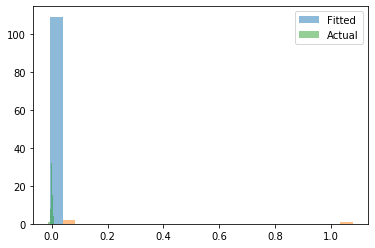

In [175]:
dst = Distribution()
dst.Fit(results2.resid)
dst.Plot(results2.resid)

In [176]:
print(dst.Fit(results.resid))
print(dst.Fit(results2.resid))

('dweibull', 0.8881303199429957)
('dweibull', 0.8881303199429957)


In [177]:
param=dst.Random()[1]

In [178]:
dist = getattr(scipy.stats, 't')
sim=dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=52)

# Simulaciones

In [181]:
simulaciones_1=pd.DataFrame()

for i in range(1000):
    dist = getattr(scipy.stats, 't')
    sim=dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=52)
    simulaciones_1[i]=results.simulate(nsimulations=52)#,measurement_shocks=sim)

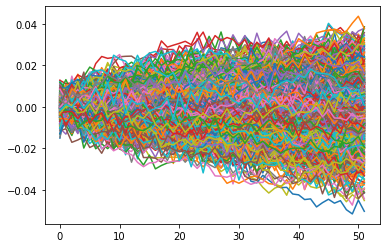

In [184]:
plt.plot(np.array(simulaciones.cumsum()))

In [183]:
simulaciones_2=pd.DataFrame()

for i in range(1000):
    #dist = getattr(scipy.stats, 't')
    #sim=dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=52)
    simulaciones_2[i]=results2.simulate(nsimulations=52)#,measurement_shocks=sim)